In [2]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from pickle import load
from IPython.display import display, clear_output
import warnings
import os
from random import sample
import imageio

warnings.filterwarnings("ignore")

#path = "C:/Users/a.rojasa55/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/"
path = os.getcwd()
cd = 0.041
cw = 0.0388

In [3]:
stations = pd.read_csv(path+"/Definite Stations.csv",index_col=[0])
vehicles = pd.read_csv(path+"/Definite Vehicles.csv",index_col=[0])
locations = pd.read_csv(path+"/Definite Locations.csv",index_col=[0])

In [4]:
K = {}; K_s = {}
for sc in range(25):
    file = open(path+f"/K/K_sc{sc}","rb")
    K[sc] = load(file); file.close()

    file = open(path+f"/K_s10/Ks_sc{sc}","rb")
    K_s[sc] = load(file); file.close()

max_stress = max([len(K_s[sc][s]) for sc in range(sc) for s in stations.index]); min_stress = 0

In [20]:
def plot_scenario(sc=0,show_vehic=True,show_size=True,show_stat=True,show_stressed=True,random_stats=False,opt_stats = None):
        img = plt.imread("C:/Users/ari_r/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Problem Visualization/Population grey.PNG")
        
        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))

        if show_vehic:
                locs = [l for l in locations.index if locations.loc[l,f"going {sc}"]>0]
                if show_size: szs = [15+12*locations.loc[l,f"going {sc}"] for l in locs]
                else: szs = [20 for l in locs]
                ax.scatter(locations["0"][locs],locations["1"][locs],s=szs,color="navy",alpha=0.5)
        
        if show_stat:
            stats = [s for s in stations.index if len(K_s[sc][s])>0]
            if show_stressed:
                cm = plt.get_cmap("gist_heat")
                for i in range(401):
                    ax.bar(x=-25,height=0.1875,width=5,bottom=37.5+0.1875*i,color=cm((1-i/400)*0.9))
                for i in range(6):
                    ax.text(x=-20,y=37.5+75*i/5,s=int((max_stress-min_stress)*i/5),va="center",ha="left",fontsize=14)
                ax.text(x=-30,y=75,rotation=90,s="stations stress index", fontsize = 14, va="center",ha="center", fontname="Century Gothic")
                cols = [cm((1-len(K_s[sc][s])/max_stress)*0.9) for s in stats]
            else:
                cols = ["darkorange" for s in stats]
            ax.scatter(stations["0"][stats],stations["1"][stats],c=cols)
        
        if random_stats:
             samp_stats = sample(list(stations.index),300)
             ax.scatter(stations["0"][samp_stats],stations["1"][samp_stats],c="yellowgreen")
            
        if opt_stats is not None:
            for s in stations.index:
                if s not in opt_stats:
                    if len(K_s[sc][s]) > 0:
                        ax.plot(stations.loc[s,"0"],stations.loc[s,"1"],color="red",linestyle="",marker="o")
                else:
                    ax.plot(stations.loc[s,"0"],stations.loc[s,"1"],color="deepskyblue",linestyle="",marker="o",markersize=7)
                 

        ax.vlines(x=[0,290],ymin=0,ymax=150,color="black")
        ax.hlines(y=[0,150],xmin=0,xmax=290,color="black")

        ax.spines[["top","bottom","left","right"]].set_visible(False)

        zero = (-5,-12)
        height = 184.425
        ax.imshow(img, extent=[zero[0], zero[0]+height*5/3, zero[1], zero[1]+height])
        
        ax.set_xlim(-40,320)
        ax.set_ylim(-20,170)
        ax.set_xticks([]); ax.set_yticks([])
        if not random_stats:
            ax.set_title(f"\nScenario {sc}\nNumber of vehicles: {len(K[sc])}",fontsize=18,fontname="Century Gothic")
        else:
            plt.savefig(path+f"/Sample Configs toy/Random_{sc}",dpi=300,transparent=True)

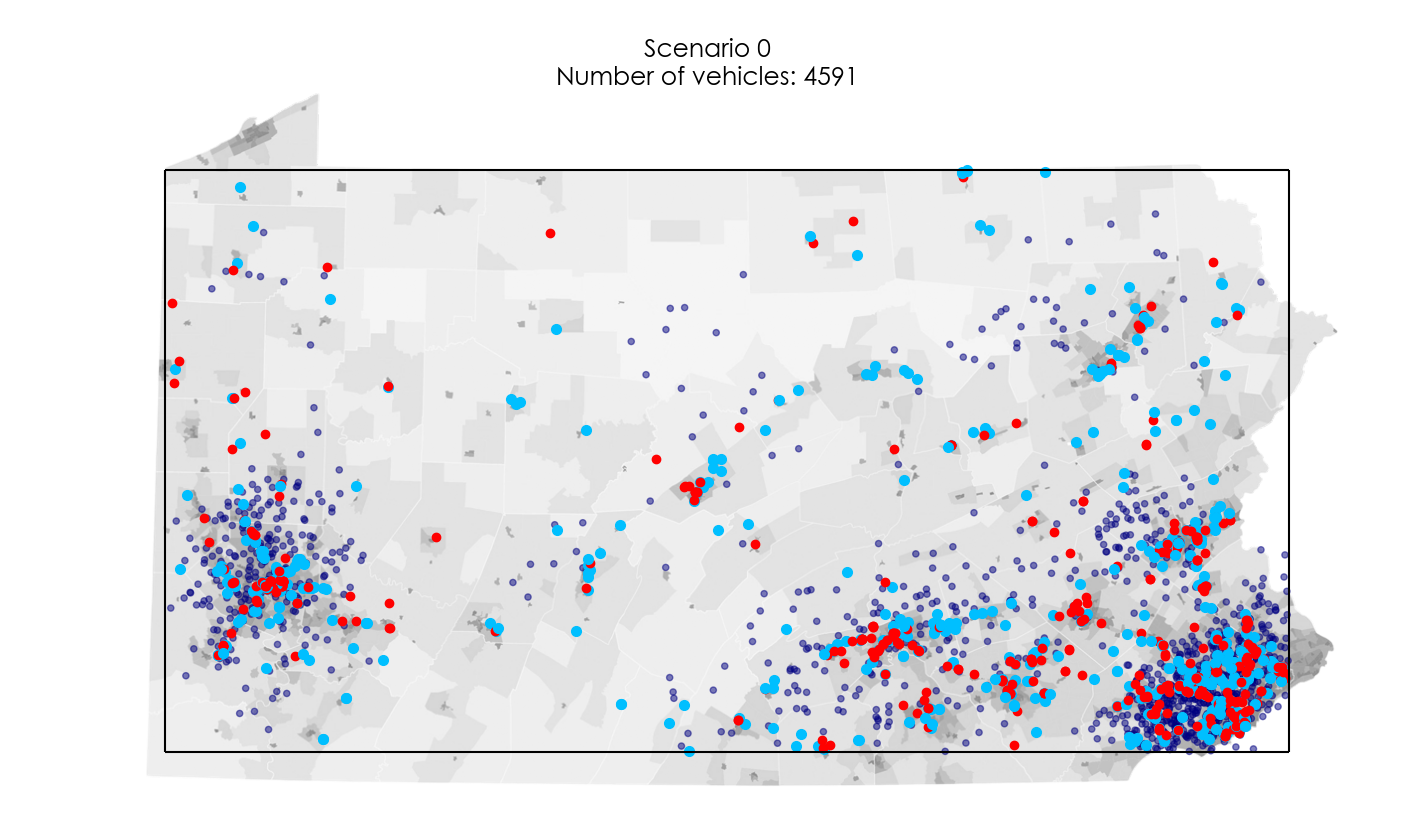

In [22]:
plot_scenario(0,show_vehic=True,show_size=False,show_stat=False,show_stressed=True,random_stats=False, opt_stats=S)

In [17]:
file = open("C:/Users/ari_r/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Results/Configurations/Open Stations/open_stations_18","rb"); S = load(file); file.close()

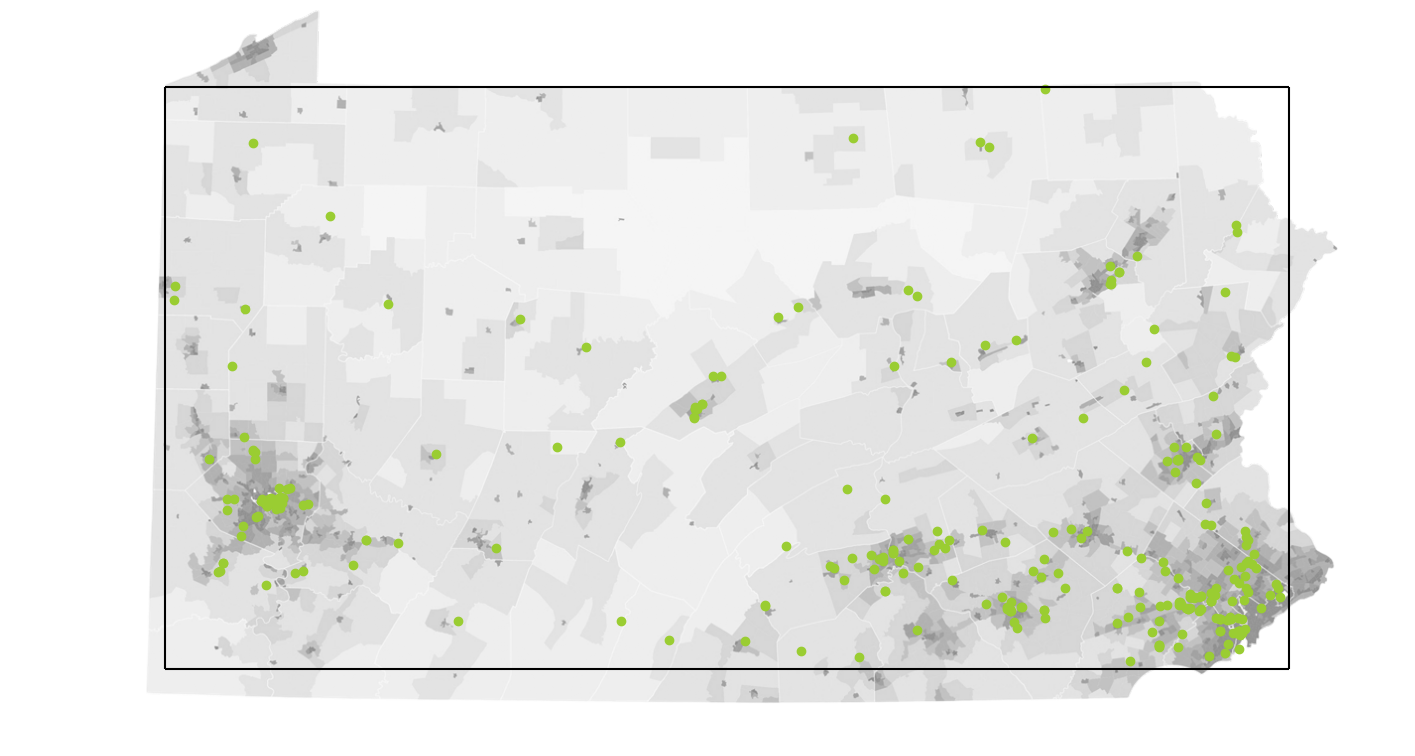

In [49]:
plot_scenario(0,show_vehic=False,show_size=True,show_stat=False,show_stressed=True,random_stats=True)

In [46]:
images = []
for sc in range(10):
    images.append(imageio.imread(path+f"/Sample Configs toy/Random_{sc}.png"))


imageio.mimsave(path+'/Sample Configs toy.gif', images,duration=1)

In [12]:
a = widgets.IntSlider(min=0,max=24,value=0,description='Scenario:',disabled=False,continuous_update=False,readout=True)
b = widgets.Checkbox(value=False,description="Vehicles",fontsize=18); c = widgets.Checkbox(value=False,description="Number of vehicles")
d = widgets.Checkbox(value=False,description="Stations"); e = widgets.Checkbox(value=False,description="Stations stress index")
ui = widgets.HBox([a, b, c, d, e])
def f(a, b, c, d, e):
    plot_scenario(sc=a,show_vehic=b,show_size=c,show_stat=d,show_stressed=e)

out = widgets.interactive_output(f, {"a": a, "b": b, "c": c, "d": d, "e": e})


In [13]:
display(ui, out)


Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1800x1200 with 1 Axes>', …